In [1]:
import pandas as pds
import matplotlib.pylab as plt
import numpy as np
import json
%matplotlib inline

df_train = pds.read_csv('Train.csv')
df_test = pds.read_csv('Test.csv')

# Kaggle: Предсказание цены недвижимости

In [2]:
df_train.info

<bound method DataFrame.info of           id    date  street_id  build_tech  floor  area  rooms  balcon  \
0          0  2011-1        121         1.0      3    52      2       1   
1          1  2011-1         58         1.0      6   101      3       1   
2          2  2011-1        530         0.0     11    71      3       0   
3          3  2011-1        448         NaN      5    36      1       1   
4          4  2011-1        404         2.0      3   215      6       2   
5          5  2011-1        443         1.0      3    52      2       1   
6          6  2011-1        452         0.0      5    59      3       0   
7          7  2011-1         25         0.0      7    38      1       0   
8          8  2011-1        193         1.0      9    52      2       1   
9          9  2011-1        419         NaN      5    34      1       1   
10        10  2011-1        498         NaN      2    35      1       0   
11        11  2011-1        173         1.0      7    61      3     

## Обработка данных:даты - год, месяц, сезон; фильтрация nan


In [3]:
def date_string_to_year(str):
    v = str.split('-')
    #print v
    
    return int(v[0])

def date_string_to_season(str):
    v = str.split('-')
    #print v
    val = int(v[1])
    if (val<=3):
        return 1
    else:
        if val<=6:
            return 2
        else:
            if val<=9:
                return 3 
    return 4

def date_string_to_month(str):
    v = str.split("-")
    return int(v[1])

def date_to_num(str):
    v = str.split('-')
    #print v
    return (int(v[0]) - 2011)*12 + int(v[1])

def data_preprocessing(df_train):
    df_train['date_year'] = df_train['date'].map(lambda x: date_string_to_year(x))
    df_train['date_month'] = df_train['date'].map(lambda x: date_string_to_month(x))
    df_train['date_num'] = df_train['date'].map(lambda x: date_to_num(x))
    df_train['date_season'] = df_train['date'].map(lambda x: date_string_to_season(x))
    is_nan_values = ['build_tech','g_lift','metro_dist']
    for el in is_nan_values:
        non_nan = df_train.loc[np.isnan(df_train[el]) == False] 
        val = np.mean(non_nan[el])
        df_train.loc[np.isnan(df_train[el]),el] = val
    return df_train

df_train = data_preprocessing(df_train)



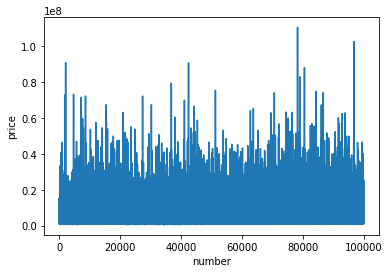

In [4]:
y_train = df_train['price']
plt.plot(y_train)
plt.xlabel('number')
plt.ylabel('price')

In [5]:


#COLUMNS2 = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
COLUMNS2 = ['date_year','date_month', 'street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist',  'n_photos']

#COLUMNS2 = ['date_year','date_month',  'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'g_lift', 'n_photos']
#COLUMNS2 = ['date_num','date_month',  'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'g_lift', 'n_photos']

X = df_train[COLUMNS2]
Y = df_train['price']
import xgboost as xgb

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.ensemble

def validation_err(df_train,reg):
    df_newtest = df_train.loc[df_train['date'] == '2012-3']
    df_newtrain = df_train.loc[df_train['date'] != '2012-3']
    Xnew_test = df_newtest[COLUMNS2]
    Ynew_test = df_newtest['price']
    Xnew_train = df_newtrain[COLUMNS2]
    Ynew_train = df_newtrain['price']
    reg.fit(Xnew_train,Ynew_train)
    Y_pred_test = reg.predict(Xnew_test)
    return mean_absolute_error(Y_pred_test,Ynew_test)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error    
#min_max_scaler = MinMaxScaler()
#reg = GradientBoostingRegressor(verbose=False, random_state=42, max_depth=10, learning_rate=0.9)
#reg = LogisticRegression(penalty='l2')
#lin = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
#reg = sklearn.ensemble.RandomForestRegressor()
#reg = sklearn.ensemble.RandomForestRegressor(n_estimators =15)
#max_depthes = [30,35,40,45,50,55,65,70,75,80,85,90,100,110]
#n_estimators = [45,50,55,60,65,70,75,80,85,90,95,100,110]
max_depthes = [8]
n_estimators = [700]

i = 0
vals = {'val':[], 'depth':[], 'est':[], 'file_n':[], 'val-err':[]}

df_test = data_preprocessing(df_test)
X_test = df_test[COLUMNS2]

scaler = StandardScaler()
scaler.fit(X)
X_scale_train = scaler.transform(X)
import xgboost as xgb
#reg = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=5, nthread=4)
for depth in max_depthes:
    for n_est in n_estimators:
        reg = xgb.XGBRegressor(max_depth=depth, n_estimators=n_est, nthread=4, random_state=42)
        #reg = sklearn.ensemble.RandomForestRegressor(oob_score=True, max_depth=depth, n_estimators = n_est, random_state= 42)
        reg.fit(X,Y)
        Y_train_pred = reg.predict(X)
        fun = mean_absolute_error(Y_train_pred,Y)
        df_new = pds.DataFrame()
        
        Y_test = reg.predict(X_test)
        df_new['id'] = df_test['id']
        df_new['price'] = Y_test

        df_new.to_csv('new_test'+str(i)+'.csv', columns = ['id','price'], index=False)
        i+=1
        vals['dile_n'] = i
        vals['val'].append(fun)
        vals['depth'].append(depth)
        vals['est'].append(n_est)
        vals['val-err'].append(validation_err(df_train,reg))
        with open('result_'+str(i)+'.json', 'w') as fp:
            json.dump(vals, fp)
print vals


{'est': [700], 'val-err': [931529.09146627493], 'val': [485099.33210417966], 'depth': [8], 'file_n': [], 'dile_n': 1}


In [7]:
np.min(vals['val-err'])
i = np.argmin(vals['val-err'])
print i
vals['val'][i]
vals['val-err'][i]
print 'Depth:', vals['depth'][i]
print 'Est:', vals['est'][i]

0
Depth: 8
Est: 700


# Ошибка на обучающей выборке

In [8]:
print mean_absolute_error(Y_train_pred,Y)

485099.332104


# Ошибка на тестовом подмножестве обучающей выборке

In [9]:
print validation_err(df_train,reg)

931529.091466


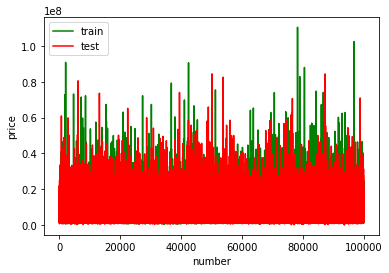

In [10]:
df_new = pds.DataFrame()
df_new['id'] = df_test['id']
df_new['price'] = Y_test

df_new.to_csv(str(int(vals['val'][0]))+'.csv', columns = ['id','price'], index=False)

plt.plot(Y,'g',label='train')
plt.plot(Y_test,'r', label='test')
plt.legend()
plt.xlabel('number')
plt.ylabel('price')


In [11]:
np.max(Y_test)

84413808.0